Import Library

In [13]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot

import warnings
warnings.filterwarnings('ignore')

Membaca data csv

In [2]:
customer= pd.read_csv("/content/Case Study - Customer.csv",delimiter=';')
product= pd.read_csv("/content/Case Study - Product.csv",delimiter=';')
store= pd.read_csv("/content/Case Study - Store.csv",delimiter=';')
transaction = pd.read_csv("/content/Case Study - Transaction.csv",delimiter=';')

In [3]:
customer.shape,product.shape, store.shape, transaction.shape

((447, 5), (10, 3), (14, 6), (5020, 8))

Melakukan data cleansing

In [4]:
customer.head()

,CustomerID,Age,Gender,Marital Status,Income
0,1,55,1,Married,"5,12"
1,2,60,1,Married,"6,23"
2,3,32,1,Married,"9,17"
3,4,31,1,Married,"4,87"
4,5,58,1,Married,"3,57"


In [5]:
product.head()

,ProductID,Product Name,Price
0,P1,Choco Bar,8800
1,P2,Ginger Candy,3200
2,P3,Crackers,7500
3,P4,Potato Chip,12000
4,P5,Thai Tea,4200


In [6]:
store.head()

,StoreID,StoreName,GroupStore,Type,Latitude,Longitude
0,1,Prima Tendean,Prima,Modern Trade,"-6,2","106,816666"
1,2,Prima Kelapa Dua,Prima,Modern Trade,"-6,914864","107,608238"
2,3,Prima Kota,Prima,Modern Trade,"-7,797068","110,370529"
3,4,Gita Ginara,Gita,General Trade,"-6,966667","110,416664"
4,5,Bonafid,Gita,General Trade,"-7,250445","112,768845"


In [7]:
transaction.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
0,TR11369,328,01/01/2022,P3,7500,4,30000,12
1,TR16356,165,01/01/2022,P9,10000,7,70000,1
2,TR1984,183,01/01/2022,P1,8800,4,35200,4
3,TR35256,160,01/01/2022,P1,8800,7,61600,4
4,TR41231,386,01/01/2022,P9,10000,1,10000,4


In [8]:
#cleansing data customer
customer['Income'] = customer['Income'].str.replace(',', '.', regex=True).astype(float)

In [9]:
#cleansing data store
store['Latitude'] = store['Latitude'].replace(',', '.', regex=True).astype(float)
store['Longitude'] = store['Longitude'].str.replace(',', '.', regex=True).astype(float)

In [10]:
#cleansing data transaction
transaction['Date'] = pd.to_datetime(transaction['Date'])

In [12]:
print(store['Latitude'].dtype)
print(store['Longitude'].dtype)

float64
float64


Menggabungkan semua data menjadi 1 data

In [14]:
merged_data = pd.merge(customer, transaction, on='CustomerID')
merged_data = pd.merge(merged_data, product, on='ProductID')
merged_data = pd.merge(merged_data, store, on='StoreID')
merged_data.head()

,CustomerID,Age,Gender,Marital Status,Income,TransactionID,Date,ProductID,Price_x,Qty,TotalAmount,StoreID,Product Name,Price_y,StoreName,GroupStore,Type,Latitude,Longitude
0,1,55,1,Married,5.12,TR54475,2022-02-23,P8,16000,1,16000,9,Oat,16000,Lingga,Lingga,Modern Trade,-3.654703,128.190643
1,5,58,1,Married,3.57,TR53643,2022-05-22,P8,16000,3,48000,9,Oat,16000,Lingga,Lingga,Modern Trade,-3.654703,128.190643
2,7,31,0,Married,4.57,TR5151,2022-10-03,P8,16000,2,32000,9,Oat,16000,Lingga,Lingga,Modern Trade,-3.654703,128.190643
3,19,24,1,Single,4.14,TR98635,2022-06-18,P8,16000,1,16000,9,Oat,16000,Lingga,Lingga,Modern Trade,-3.654703,128.190643
4,28,55,0,Married,6.08,TR9420,2022-12-01,P8,16000,3,48000,9,Oat,16000,Lingga,Lingga,Modern Trade,-3.654703,128.190643


Membuat model machine learning regression (time series)

In [18]:
regresi = merged_data.groupby(['Date']).agg({'Qty' : 'sum'}).reset_index()
regresi

,Date,Qty
0,2022-01-01,49
1,2022-01-02,50
2,2022-01-03,76
3,2022-01-04,98
4,2022-01-05,67
...,...,...
360,2022-12-27,70
361,2022-12-28,68
362,2022-12-29,42
363,2022-12-30,44


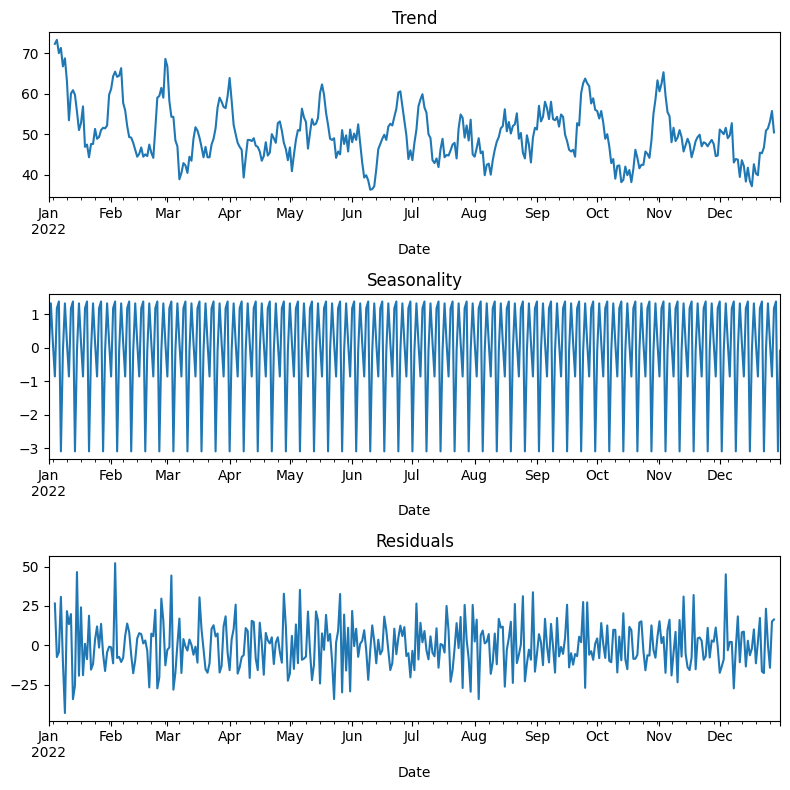

In [20]:
decomposed = seasonal_decompose(regresi.set_index('Date'))

plt.figure(figsize=(8, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

In [25]:
cut_off = round(regresi.shape[0] * 0.9)
df_train = regresi.iloc[:cut_off]
df_test = regresi.iloc[cut_off:].reset_index(drop=True)
df_train.shape, df_test.shape

((328, 2), (37, 2))

In [24]:
df_train

,Date,Qty
0,2022-01-01,49
1,2022-01-02,50
2,2022-01-03,76
3,2022-01-04,98
4,2022-01-05,67
...,...,...
323,2022-11-20,55
324,2022-11-21,55
325,2022-11-22,49
326,2022-11-23,40


In [26]:
df_test

,Date,Qty
0,2022-11-25,55
1,2022-11-26,40
2,2022-11-27,53
3,2022-11-28,50
4,2022-11-29,55
5,2022-11-30,45
6,2022-12-01,35
7,2022-12-02,34
8,2022-12-03,41
9,2022-12-04,98


<Axes: xlabel='Date', ylabel='Qty'>

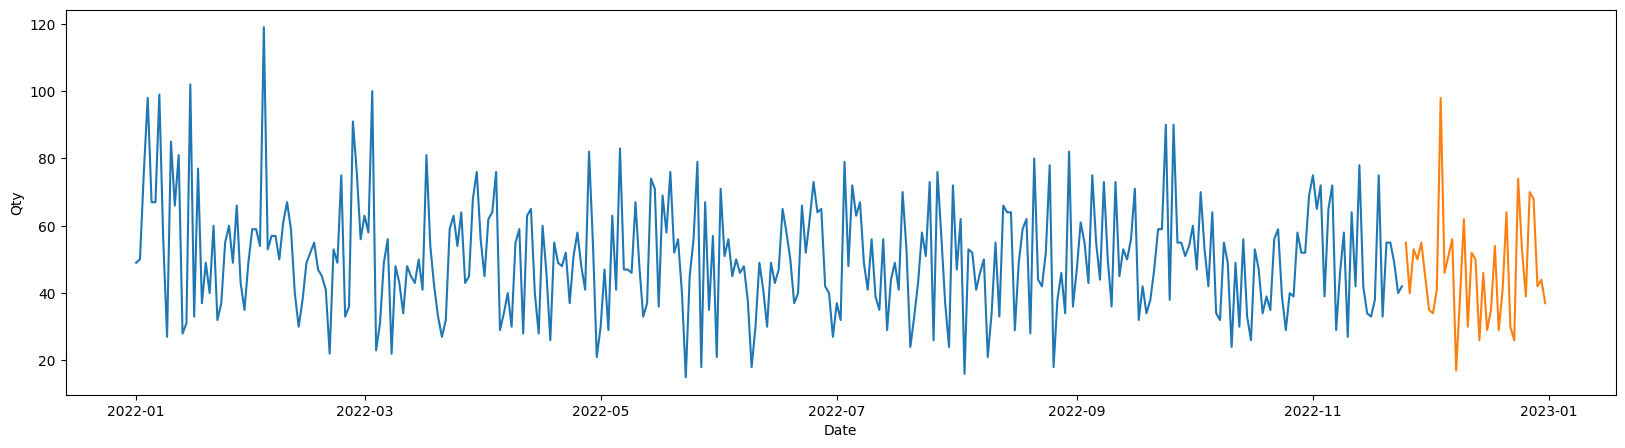

In [27]:
plt.figure(figsize=(20, 5))
sns.lineplot(data=df_train, x=df_train['Date'], y=df_train['Qty']);
sns.lineplot(data=df_test, x=df_test['Date'], y=df_test['Qty'])

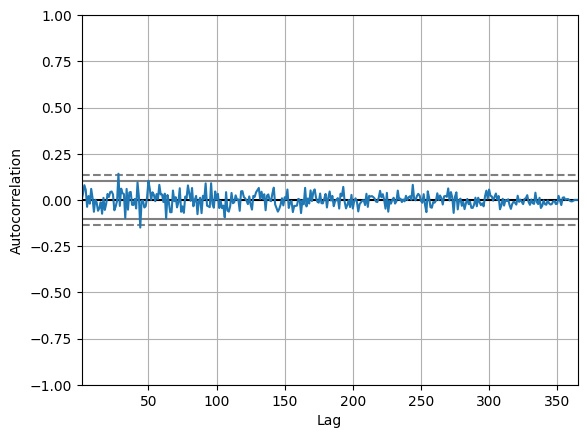

In [29]:
autocorrelation_plot(regresi['Qty']);

In [30]:
def rmse(y_actual, y_pred):
    """
    function to calculate RMSE
    """

    print(f'RMSE value {mean_squared_error(y_actual, y_pred)**0.5}')

def eval(y_actual, y_pred):
    """
    function to eval machine learning modelling
    """

    rmse(y_actual, y_pred)
    print(f'MAE value {mean_absolute_error(y_actual, y_pred)}')

RMSE value 15.989408875279329
MAE value 12.440122859395961


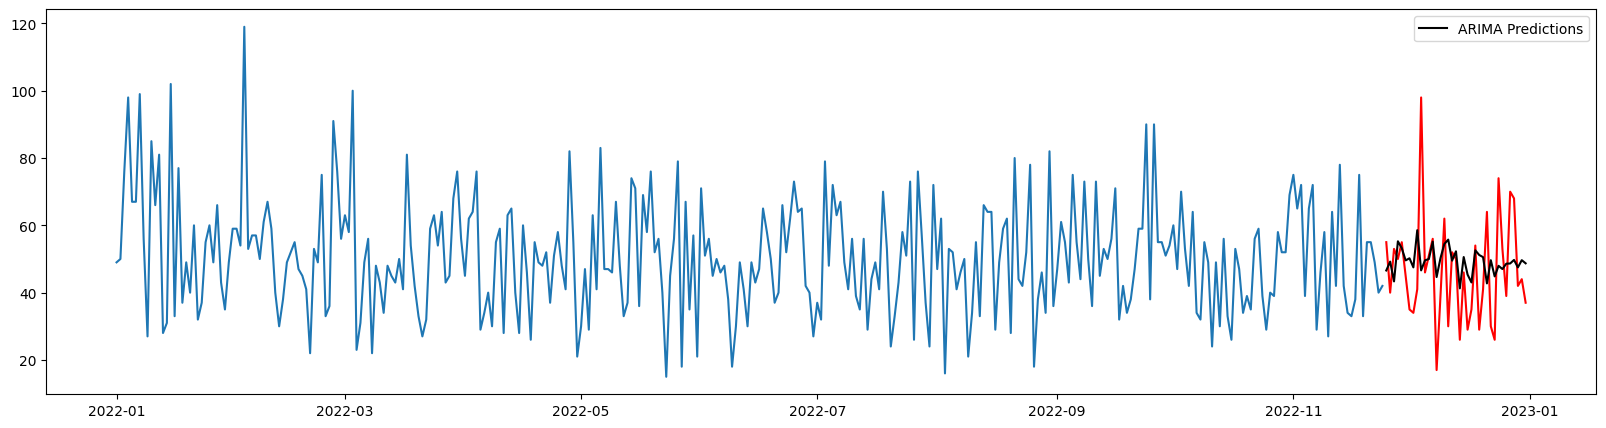

In [31]:
#ARIMA
df_train = df_train.set_index('Date')
df_test = df_test.set_index('Date')

y = df_train['Qty']

ARIMAmodel = ARIMA(y, order = (40, 2, 1))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(df_test))

y_pred_df = y_pred.conf_int()
y_pred_df['predictions'] = ARIMAmodel.predict(start =y_pred_df.index[0], end =y_pred_df.index[-1])
y_pred_df.index = df_test.index
y_pred_out = y_pred_df['predictions']
eval(df_test['Qty'], y_pred_out)

plt.figure(figsize=(20, 5))
plt.plot(df_train['Qty'])
plt.plot(df_test['Qty'], color='red')
plt.plot(y_pred_out, color='black', label = 'ARIMA Predictions')
plt.legend()

 Membuat model machine learning clustering

In [32]:
merged_data.head()

,CustomerID,Age,Gender,Marital Status,Income,TransactionID,Date,ProductID,Price_x,Qty,TotalAmount,StoreID,Product Name,Price_y,StoreName,GroupStore,Type,Latitude,Longitude
0,1,55,1,Married,5.12,TR54475,2022-02-23,P8,16000,1,16000,9,Oat,16000,Lingga,Lingga,Modern Trade,-3.654703,128.190643
1,5,58,1,Married,3.57,TR53643,2022-05-22,P8,16000,3,48000,9,Oat,16000,Lingga,Lingga,Modern Trade,-3.654703,128.190643
2,7,31,0,Married,4.57,TR5151,2022-10-03,P8,16000,2,32000,9,Oat,16000,Lingga,Lingga,Modern Trade,-3.654703,128.190643
3,19,24,1,Single,4.14,TR98635,2022-06-18,P8,16000,1,16000,9,Oat,16000,Lingga,Lingga,Modern Trade,-3.654703,128.190643
4,28,55,0,Married,6.08,TR9420,2022-12-01,P8,16000,3,48000,9,Oat,16000,Lingga,Lingga,Modern Trade,-3.654703,128.190643


In [34]:
merged_data.corr()

,CustomerID,Age,Gender,Income,Price_x,Qty,TotalAmount,StoreID,Price_y,Latitude,Longitude
CustomerID,1.000000,-0.025952,-0.009947,0.005783,-0.016423,-0.009755,-0.024915,0.004129,-0.016423,0.002278,-0.003122
Age,-0.025952,1.000000,-0.033183,0.486692,0.014693,-0.027768,-0.016900,-0.003872,0.014693,0.009266,0.015951
Gender,-0.009947,-0.033183,1.000000,-0.071443,0.010705,-0.010542,-0.008774,-0.000189,0.010705,-0.006051,-0.001183
Income,0.005783,0.486692,-0.071443,1.000000,0.001196,-0.028425,-0.025350,0.001613,0.001196,0.015518,0.004385
Price_x,-0.016423,0.014693,0.010705,0.001196,1.000000,-0.353640,0.440632,-0.032863,1.000000,-0.029008,0.018652
Qty,-0.009755,-0.027768,-0.010542,-0.028425,-0.353640,1.000000,0.621129,0.014365,-0.353640,-0.004170,0.004807
TotalAmount,-0.024915,-0.016900,-0.008774,-0.025350,0.440632,0.621129,1.000000,-0.010722,0.440632,-0.029938,0.025437
StoreID,0.004129,-0.003872,-0.000189,0.001613,-0.032863,0.014365,-0.010722,1.000000,-0.032863,0.471852,-0.094943
Price_y,-0.016423,0.014693,0.010705,0.001196,1.000000,-0.353640,0.440632,-0.032863,1.000000,-0.029008,0.018652
Latitude,0.002278,0.009266,-0.006051,0.015518,-0.029008,-0.004170,-0.029938,0.471852,-0.029008,1.000000,-0.395995


In [37]:
df_cluster = merged_data.groupby(['CustomerID']).agg({'TransactionID' : 'count','Qty' : 'sum'}).reset_index()
df_cluster.head()

,CustomerID,TransactionID,Qty
0,1,17,60
1,2,13,57
2,3,15,56
3,4,10,46
4,5,7,27


In [38]:
df_cluster

,CustomerID,TransactionID,Qty
0,1,17,60
1,2,13,57
2,3,15,56
3,4,10,46
4,5,7,27
...,...,...,...
442,443,16,59
443,444,18,62
444,445,18,68
445,446,11,42


In [41]:
data_cluster = df_cluster.drop(columns=['CustomerID'])
data_cluster_normalize = preprocessing.normalize(data_cluster)

In [42]:
K = range(2, 8)
fits = []
score = []

for k in K:
      model =KMeans(n_clusters = k, random_state = 0, n_init='auto').fit(data_cluster_normalize)

      fits.append(model)

      score.append(silhouette_score(data_cluster_normalize, model.labels_, metric='euclidean'))

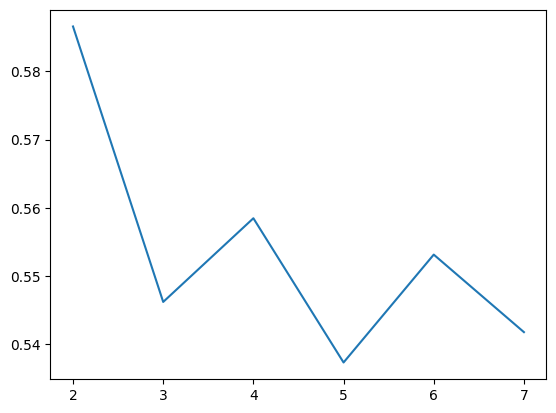

In [43]:
sns.lineplot(x = K, y = score);

In [44]:
fits[1]

KMeans(n_clusters=3, n_init='auto', random_state=0)

In [46]:
df_cluster['cluster_label'] = fits[1].labels_
df_cluster.groupby(['cluster_label']).agg({
    'CustomerID' : 'count',
    'TransactionID' : 'mean',
    'Qty' : 'mean',})

,CustomerID,TransactionID,Qty
cluster_label,,,
0,211,11.857820,42.644550
1,102,11.176471,32.637255
2,134,10.283582,44.544776
